In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
mean, std = 0.1307, 0.3081
train_dataset = datasets.MNIST("../data/", train=True, download=True,
                              transform=transforms.Compose(
                              [transforms.ToTensor(),
                              transforms.Normalize((mean,), (std,))]))
test_dataset = datasets.MNIST("../data/", train=False, download=True,
                              transform=transforms.Compose(
                              [transforms.ToTensor(),
                              transforms.Normalize((mean,), (std,))]))
n_classes = 10

In [3]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def extract_embeddings(dataloader, model, max_points=128*20):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((min(len(dataloader.dataset), max_points), 2))
        labels = np.zeros((min(len(dataloader.dataset), max_points)))
        k = 0
        for images, target in dataloader:
            if k>=max_points:
                break
            images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
#     plt.figure(figsize=(10,5))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes, loc='upper right')

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
                        nn.Linear(in_features=7*7*8, out_features=64),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=64, out_features=10),
                        nn.ReLU(inplace=True),
                        nn.Linear(in_features=10, out_features=2))
        
        self.fc2 = nn.Sequential(
                        nn.Linear(in_features=2, out_features=10),
                        nn.LogSoftmax(dim=1))
    
    def get_embedding(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view((-1, 7*7*8))
        x = self.fc1(x)
        return x
    
    def forward(self,x):
        x = self.get_embedding(x)
        x = self.fc2(x)
        return x

In [5]:
model = Model()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=392, out_features=64, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [6]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
import os
plt.figure(figsize=(12,6))
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plt.subplot(1,2,1)
plot_embeddings(train_embeddings_cl, train_labels_cl)
plt.title('Training data embeddings')
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plt.subplot(1,2,2)
plot_embeddings(val_embeddings_cl, val_labels_cl)
plt.title('Test data embeddings')
plt.savefig(os.path.join("results_cnn","Epoch_{}.png".format(0)))
plt.show()

Epoch: 1 	Time:8.30 	Training Loss:183.88 	Val Loss:132.46 	Val Accu:56.51%


Epoch: 2 	Time:8.94 	Training Loss:105.64 	Val Loss:86.52 	Val Accu:80.35%


Epoch: 3 	Time:8.70 	Training Loss:77.18 	Val Loss:64.51 	Val Accu:87.80%


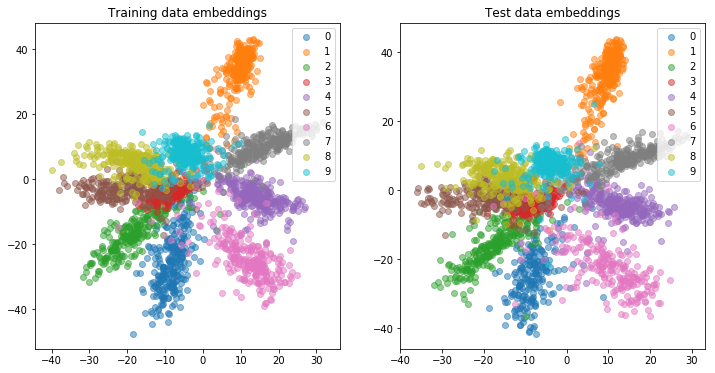

Epoch: 4 	Time:9.17 	Training Loss:59.64 	Val Loss:50.90 	Val Accu:91.68%


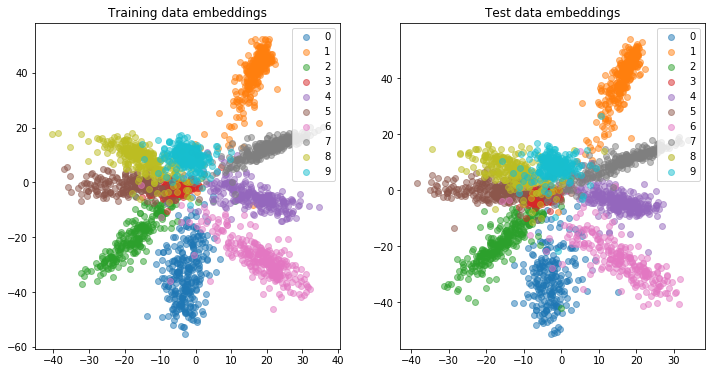

Epoch: 5 	Time:8.77 	Training Loss:48.09 	Val Loss:42.17 	Val Accu:93.18%


Epoch: 6 	Time:8.87 	Training Loss:40.69 	Val Loss:35.71 	Val Accu:94.40%


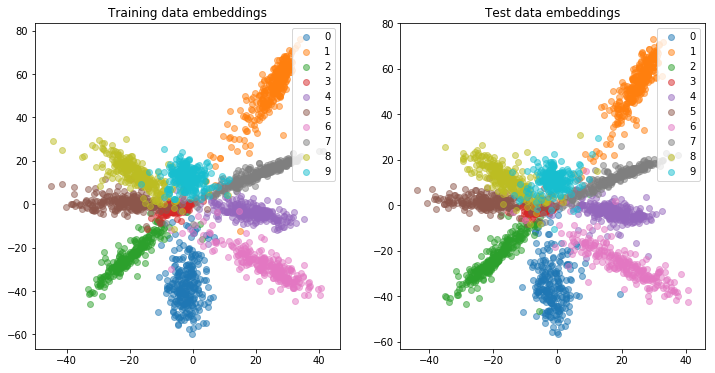

Epoch: 7 	Time:8.95 	Training Loss:35.23 	Val Loss:34.13 	Val Accu:94.68%


Epoch: 8 	Time:8.76 	Training Loss:30.91 	Val Loss:29.22 	Val Accu:95.23%


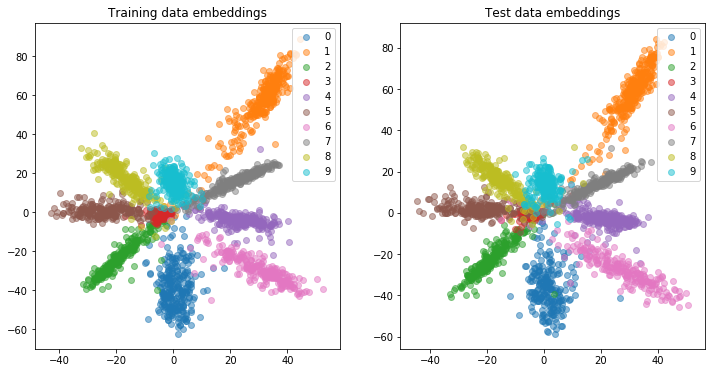

Epoch: 9 	Time:8.69 	Training Loss:27.44 	Val Loss:26.78 	Val Accu:95.93%


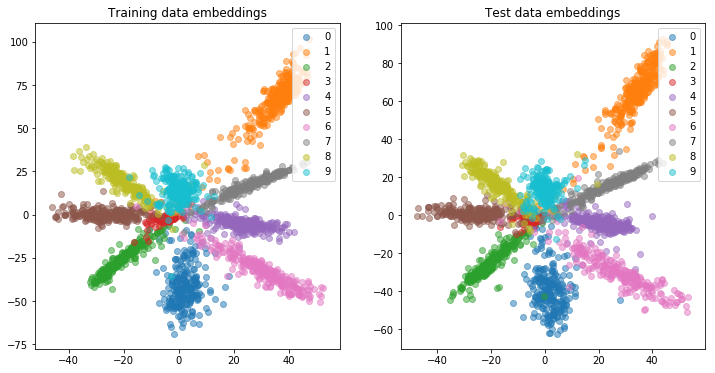

Epoch: 10 	Time:8.70 	Training Loss:24.87 	Val Loss:30.13 	Val Accu:95.32%


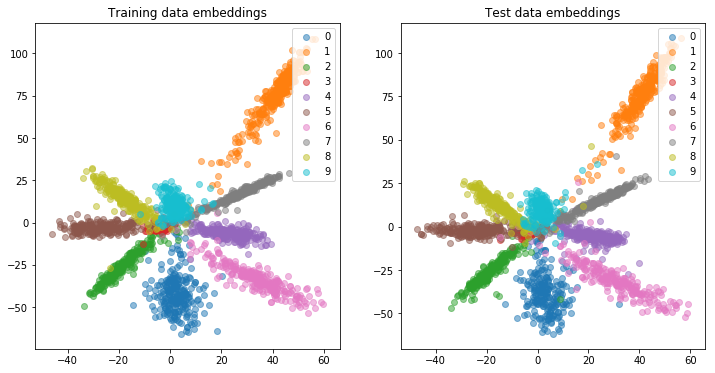

Epoch: 11 	Time:8.73 	Training Loss:23.11 	Val Loss:24.14 	Val Accu:96.21%


Epoch: 12 	Time:8.72 	Training Loss:21.65 	Val Loss:24.16 	Val Accu:96.00%


Epoch: 13 	Time:8.79 	Training Loss:20.40 	Val Loss:24.38 	Val Accu:96.23%


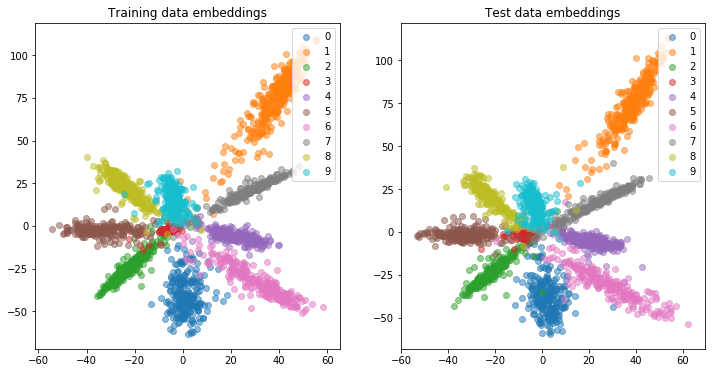

Epoch: 14 	Time:8.74 	Training Loss:19.33 	Val Loss:22.69 	Val Accu:96.49%


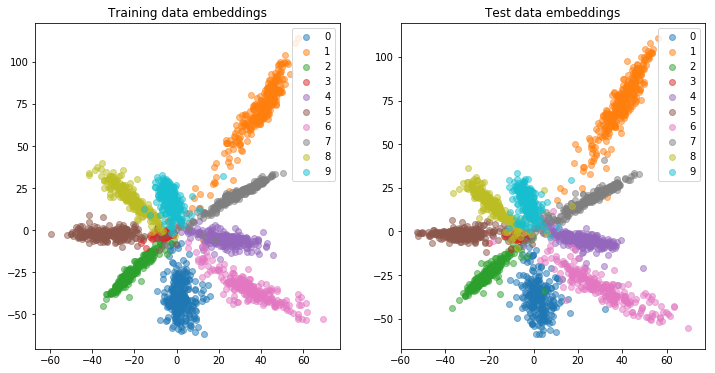

Epoch: 15 	Time:8.96 	Training Loss:18.16 	Val Loss:22.59 	Val Accu:96.68%


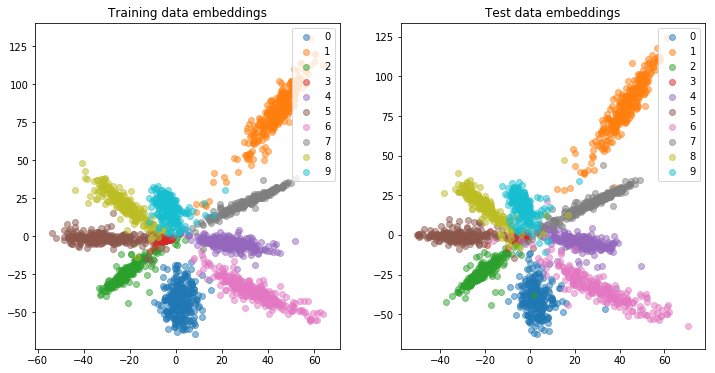

Epoch: 16 	Time:9.19 	Training Loss:17.30 	Val Loss:20.86 	Val Accu:96.68%


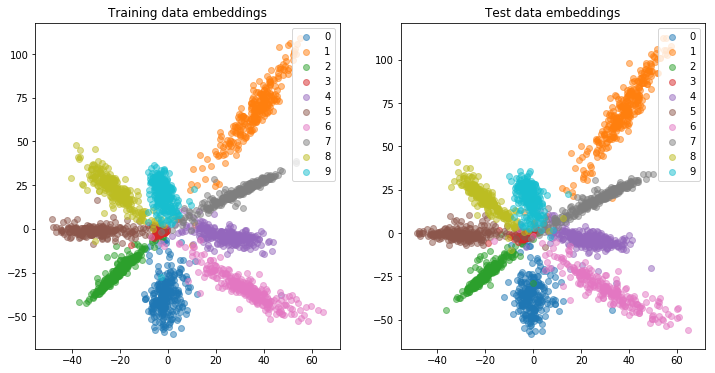

Epoch: 17 	Time:8.98 	Training Loss:16.33 	Val Loss:21.32 	Val Accu:96.81%


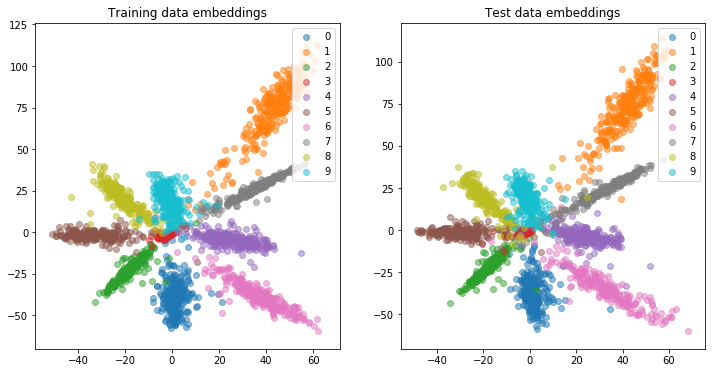

Epoch: 18 	Time:8.99 	Training Loss:15.26 	Val Loss:20.93 	Val Accu:97.04%


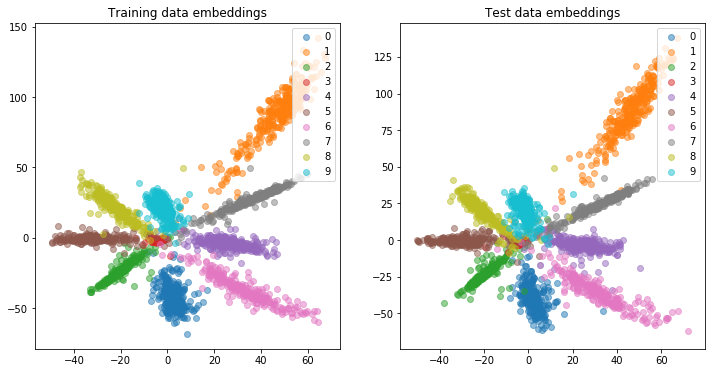

Epoch: 19 	Time:8.72 	Training Loss:14.22 	Val Loss:22.84 	Val Accu:96.91%


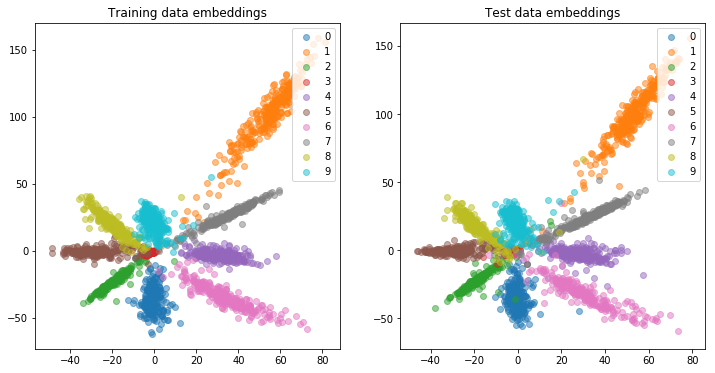

Epoch: 20 	Time:8.58 	Training Loss:13.70 	Val Loss:21.60 	Val Accu:96.55%


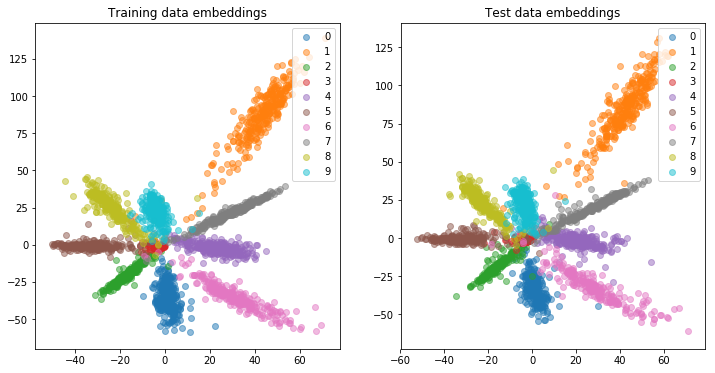

Epoch: 21 	Time:9.55 	Training Loss:13.00 	Val Loss:20.59 	Val Accu:97.31%


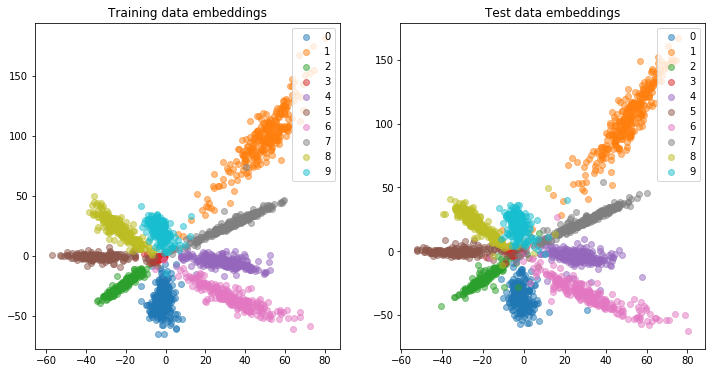

Epoch: 22 	Time:8.86 	Training Loss:12.23 	Val Loss:18.52 	Val Accu:97.35%


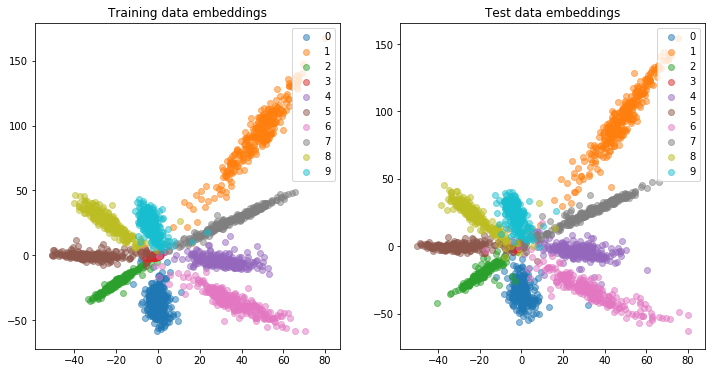

Epoch: 23 	Time:9.21 	Training Loss:11.52 	Val Loss:19.29 	Val Accu:97.46%


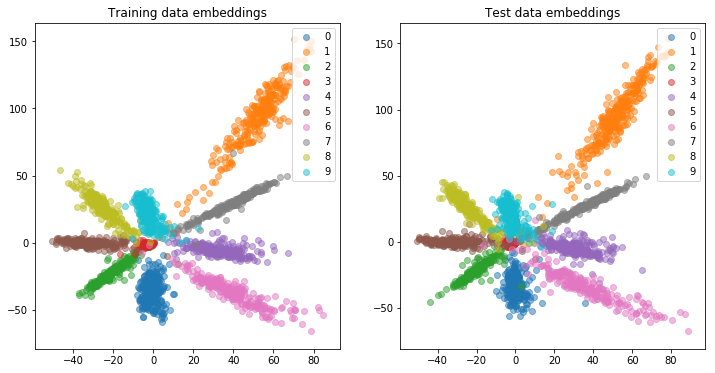

Epoch: 24 	Time:8.96 	Training Loss:10.78 	Val Loss:19.25 	Val Accu:97.39%


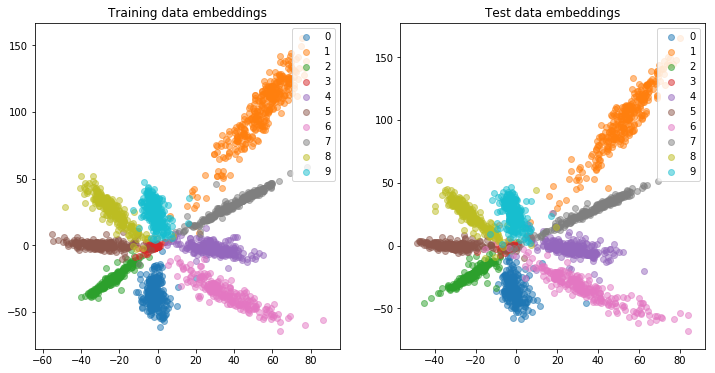

Epoch: 25 	Time:9.09 	Training Loss:10.45 	Val Loss:20.75 	Val Accu:97.29%


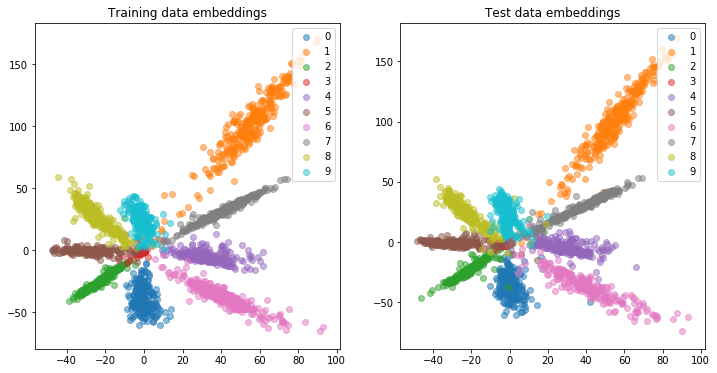

Epoch: 26 	Time:8.95 	Training Loss:9.76 	Val Loss:19.66 	Val Accu:97.51%


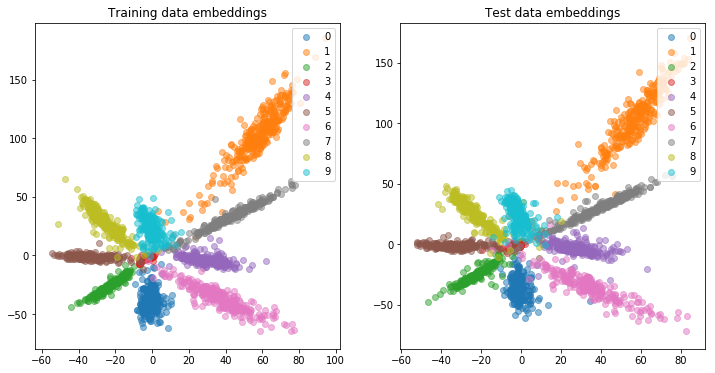

Epoch: 27 	Time:9.21 	Training Loss:9.25 	Val Loss:20.69 	Val Accu:97.53%


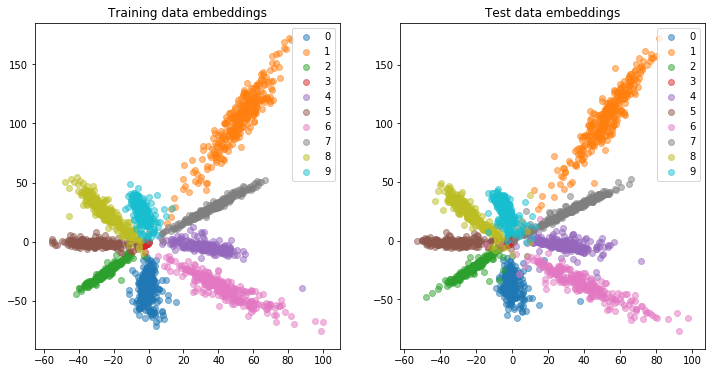

Epoch: 28 	Time:9.08 	Training Loss:9.04 	Val Loss:21.11 	Val Accu:97.48%


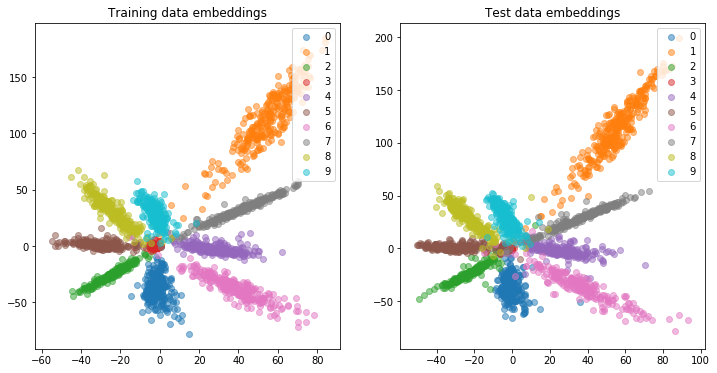

Epoch: 29 	Time:9.62 	Training Loss:8.29 	Val Loss:19.47 	Val Accu:97.48%


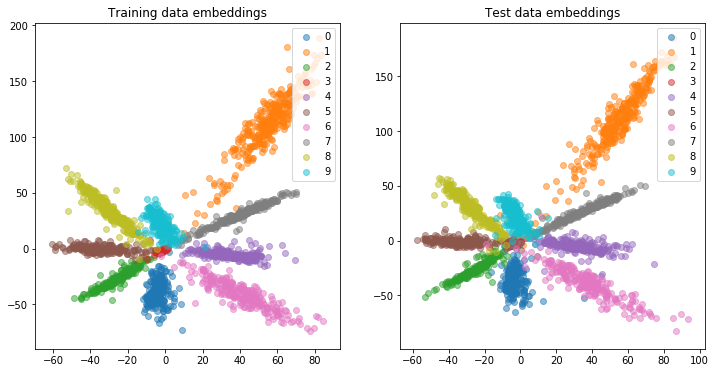

Epoch: 30 	Time:9.33 	Training Loss:7.95 	Val Loss:21.15 	Val Accu:97.68%


Epoch: 31 	Time:9.13 	Training Loss:7.33 	Val Loss:20.06 	Val Accu:97.66%


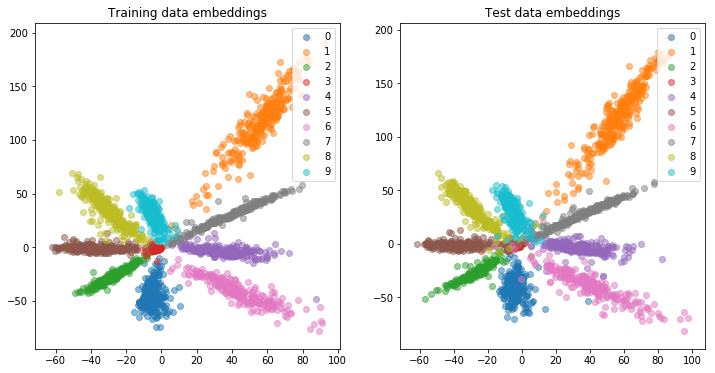

Epoch: 32 	Time:9.09 	Training Loss:7.03 	Val Loss:21.10 	Val Accu:97.63%


Epoch: 33 	Time:9.05 	Training Loss:6.86 	Val Loss:21.23 	Val Accu:97.56%


Epoch: 34 	Time:10.11 	Training Loss:6.83 	Val Loss:20.66 	Val Accu:97.79%


Epoch: 35 	Time:9.12 	Training Loss:6.19 	Val Loss:22.28 	Val Accu:97.78%


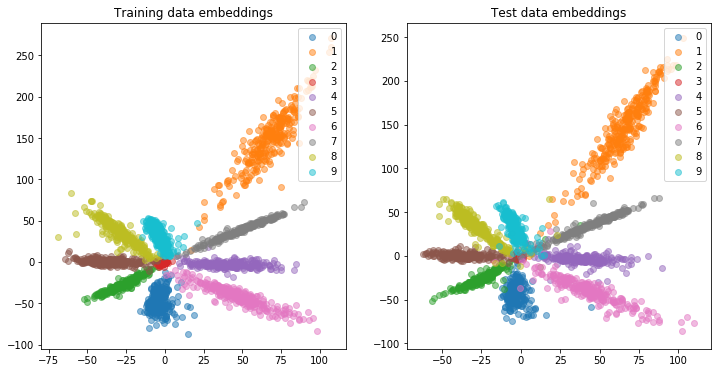

Epoch: 36 	Time:9.17 	Training Loss:5.48 	Val Loss:23.26 	Val Accu:97.77%


Epoch: 37 	Time:9.42 	Training Loss:5.91 	Val Loss:20.77 	Val Accu:97.66%


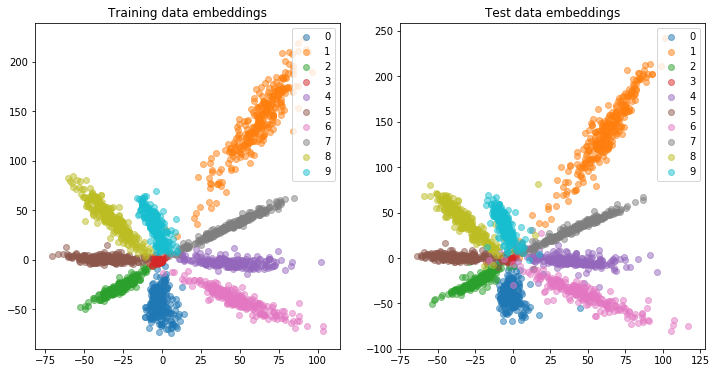

Epoch: 38 	Time:9.68 	Training Loss:5.67 	Val Loss:24.84 	Val Accu:97.58%


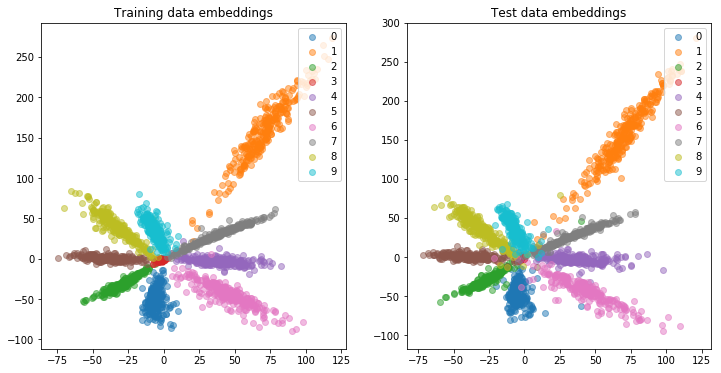

Epoch: 39 	Time:9.46 	Training Loss:5.34 	Val Loss:20.73 	Val Accu:97.69%


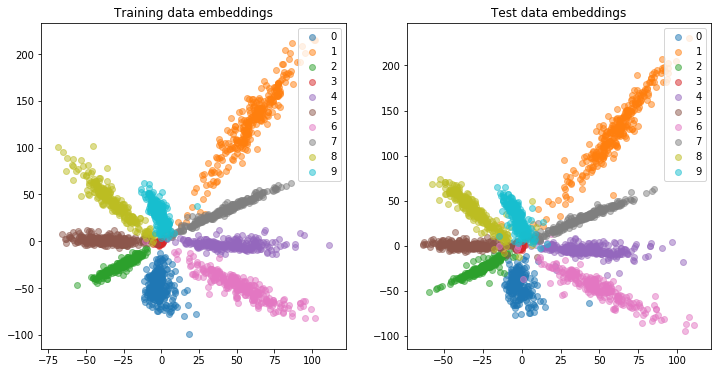

Epoch: 40 	Time:9.18 	Training Loss:5.14 	Val Loss:20.66 	Val Accu:97.96%


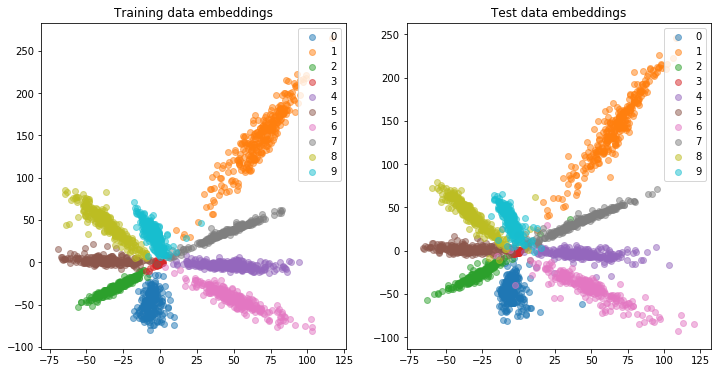

Epoch: 41 	Time:9.37 	Training Loss:4.71 	Val Loss:22.74 	Val Accu:97.68%


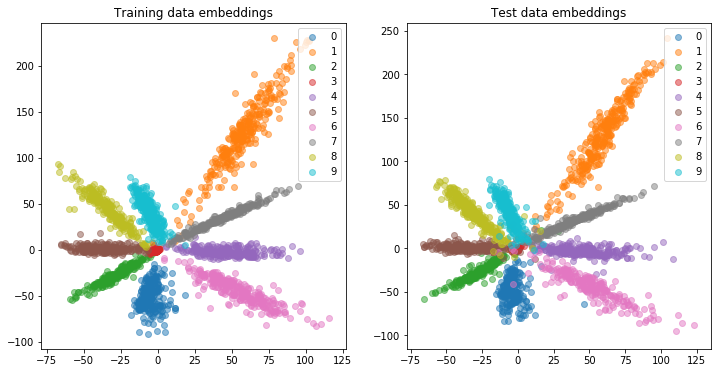

Epoch: 42 	Time:9.45 	Training Loss:4.60 	Val Loss:21.90 	Val Accu:97.75%


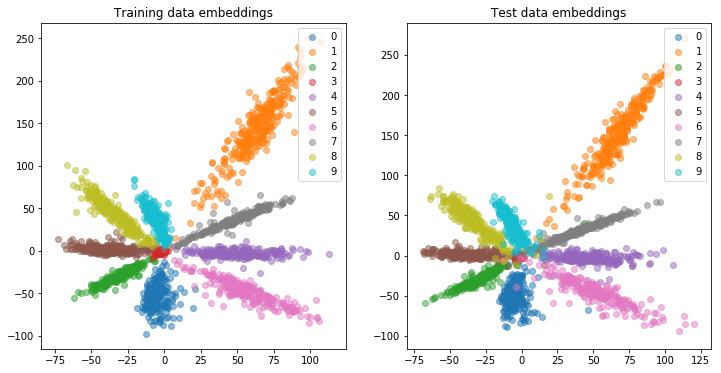

Epoch: 43 	Time:9.20 	Training Loss:4.60 	Val Loss:24.57 	Val Accu:97.74%


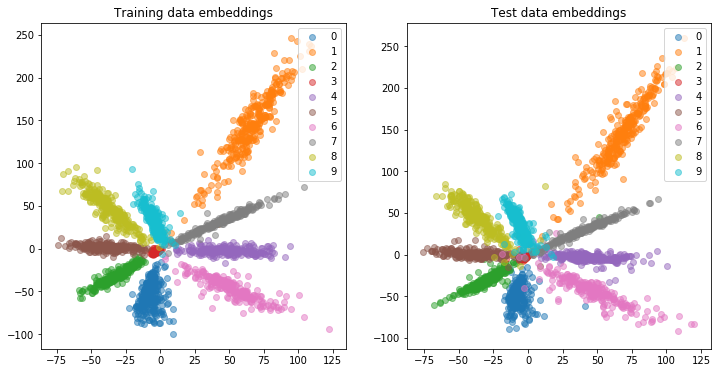

Epoch: 44 	Time:9.18 	Training Loss:4.28 	Val Loss:24.03 	Val Accu:97.74%


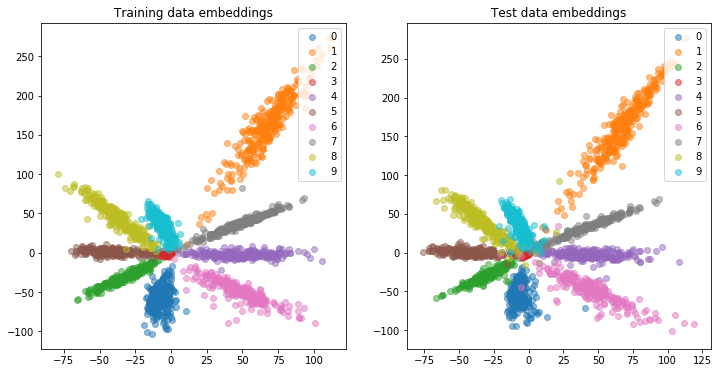

Epoch: 45 	Time:9.25 	Training Loss:3.99 	Val Loss:27.77 	Val Accu:97.41%


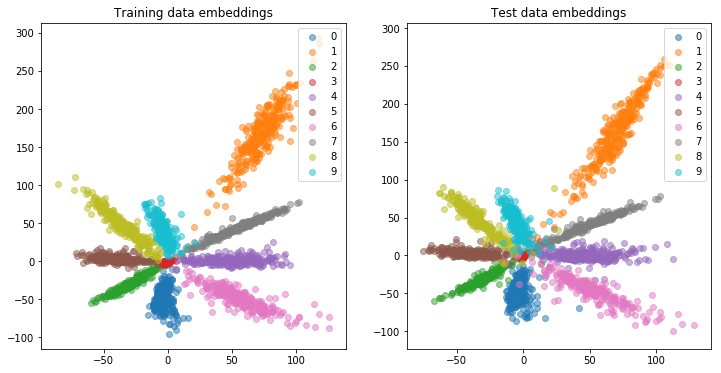

Epoch: 46 	Time:9.18 	Training Loss:3.86 	Val Loss:24.08 	Val Accu:97.80%


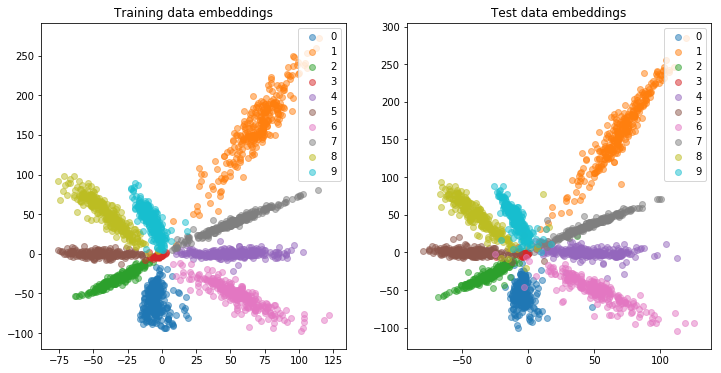

Epoch: 47 	Time:9.20 	Training Loss:3.87 	Val Loss:23.36 	Val Accu:97.85%


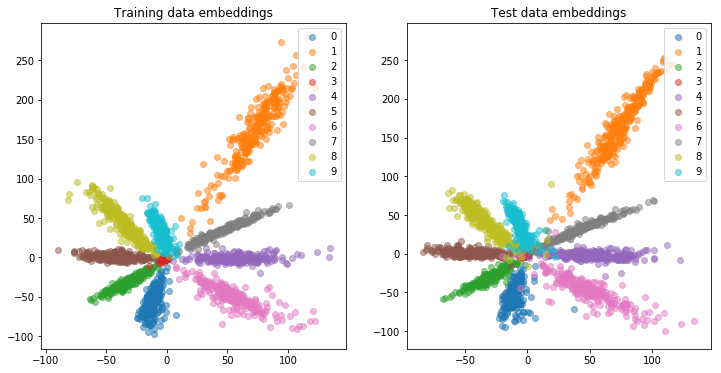

Epoch: 48 	Time:9.18 	Training Loss:3.46 	Val Loss:23.47 	Val Accu:97.83%


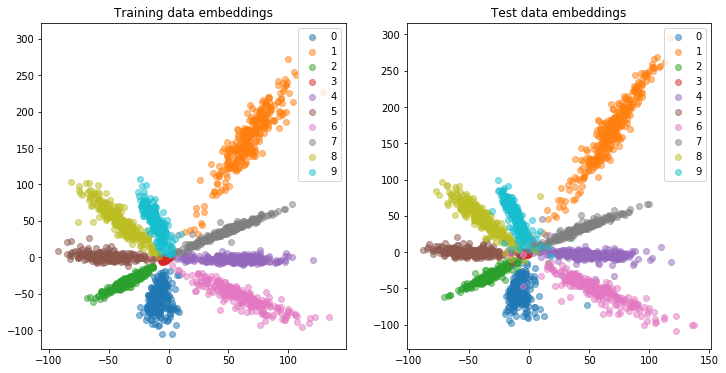

Epoch: 49 	Time:9.12 	Training Loss:3.71 	Val Loss:26.16 	Val Accu:97.61%


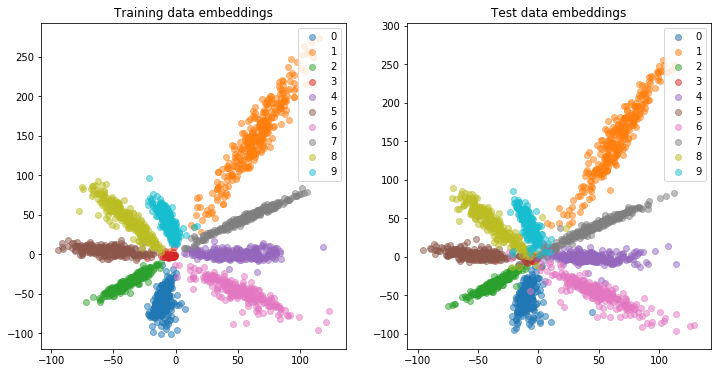

Epoch: 50 	Time:9.35 	Training Loss:4.48 	Val Loss:27.27 	Val Accu:97.87%


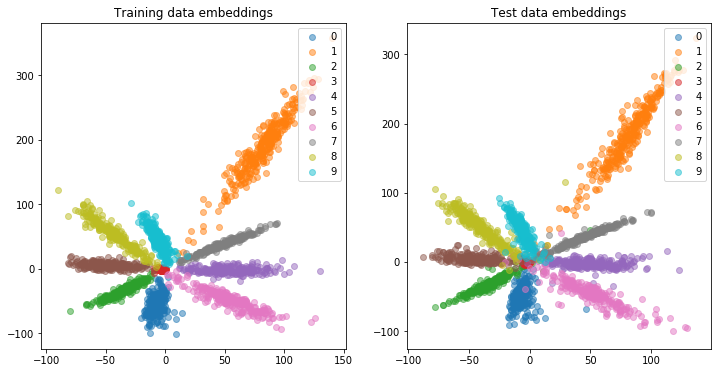

In [8]:
n_epochs = 50
import time
dataiter = iter(test_loader)
train_loss_hist = []
test_loss_hist = []
test_accu_hist = []
prevTime = time.time()

for epoch in range(1, n_epochs+1):
    train_loss = 0
    for data in train_loader:
        images, target = data
        images = images.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    test_loss = 0
    test_accu = 0
    with torch.no_grad():
        for data in test_loader:
            images, target = data
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            loss = loss_fn(output, target)
            test_loss += loss.item()*images.size(0)
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class==target.view(*top_class.shape)
            test_accu += torch.mean(equals.type(torch.FloatTensor))
            
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)
    test_accu = test_accu/len(test_loader)*100
    
    curTime = time.time()
    print('Epoch: {} \tTime:{:.2f} \tTraining Loss:{:.2f} \tVal Loss:{:.2f} \tVal Accu:{:.2f}%'.format(epoch,curTime-prevTime,train_loss, \
          test_loss, test_accu))
    prevTime = curTime
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    test_accu_hist.append(test_accu)
    plt.figure(figsize=(12,6))
    train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
    plt.subplot(1,2,1)
    plot_embeddings(train_embeddings_cl, train_labels_cl)
    plt.title('Training data embeddings')
    val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
    plt.subplot(1,2,2)
    plot_embeddings(val_embeddings_cl, val_labels_cl)
    plt.title('Test data embeddings')
    plt.savefig(os.path.join("results_cnn","Epoch_{}.png".format(epoch)))
    plt.show()
    print("===========================================================================================")

In [9]:
# with torch.no_grad():
#     data = next(iter(test_loader))
#     images, target = data
#     images = images.to(device)
#     target = target.to(device)
#     output = model(images)
#     loss = loss_fn(output, target)
# #     test_loss += loss.item()*imaeges.size(0)
#     ps = torch.exp(output)
#     top_p, top_class = ps.topk(1, dim=1)
#     equals = top_class==target.view(*top_class.shape)

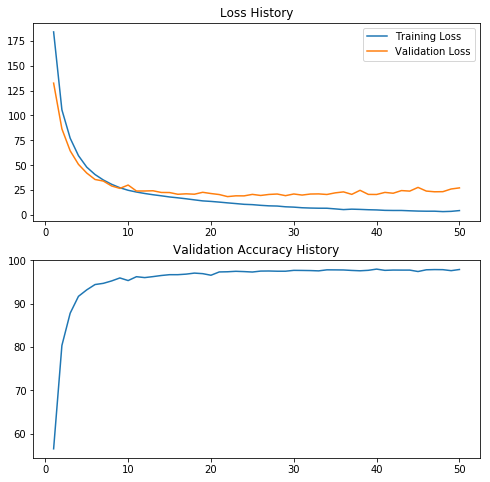

In [10]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(range(1,len(train_loss_hist)+1), train_loss_hist, label="Training Loss")
plt.plot(range(1,len(test_loss_hist)+1), test_loss_hist, label="Validation Loss")
plt.legend()
plt.title("Loss History")
plt.subplot(2,1,2)
plt.plot(range(1,len(test_accu_hist)+1), test_accu_hist, label="Validation Accuracy")
plt.title("Validation Accuracy History")
plt.savefig(os.path.join("results_cnn","Training History.png"))

In [11]:
from sklearn.linear_model import LogisticRegression
embeddings, labels = extract_embeddings(train_loader, model)
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
clf.fit(embeddings,labels)
test_embeddings, test_labels = extract_embeddings(test_loader, model)
test_pred = clf.predict(test_embeddings)
print("Test accuracy using simple classifier on embeddings: {}%".format(100*sum(test_pred==test_labels)/len(test_pred)))

/home/nan/anaconda3/envs/pytorch_learn/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Test accuracy using simple classifier on embeddings: 97.109375%


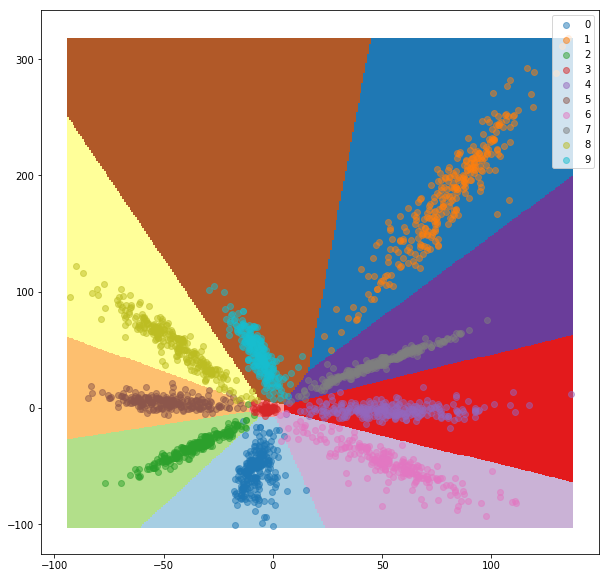

In [14]:
x_min, x_max = min(embeddings[:,0])-1, max(embeddings[:,0])+1
y_min, y_max = min(embeddings[:,1])-1, max(embeddings[:,1])+1
h = max(x_max-x_min, y_max-y_min)/500
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(X)
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,10))

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plot_embeddings(embeddings, labels)

plt.savefig(os.path.join("results_cnn","Simple Classifier.png".format(epoch)))